In [1]:
import numpy as np
import pandas as pd
import os
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [2]:
import gc
from math import sqrt
from sklearn.metrics import roc_auc_score
import pickle

import lightgbm as lgb
import math as mt
from math import *
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict


import joblib
import random
import itertools
import scipy as sp

from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

In [3]:
class CFG:
    seed = 34+42
    n_folds = 5
    target = 'target'
    input_dir = '../src/data/processed/'
    dpv = 'v2'
    mv = 'v5'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_public.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_public.parquet')
    test['D_86_last'] = np.where(test['D_86_last']==-1, 0, test['D_86_last'])
    dcols = [col for col in train.columns if '_isFirstEq' in col] + [col for col in train.columns if '_isLastEq' in col]
    train = train.drop(dcols, axis=1)
    test = test.drop(dcols, axis=1)
    return train, test

def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

def amex_metric_np(preds, target):
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)
    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)
    g = gini / gini_max
    return 0.5 * (g + d)

In [29]:
seed_everything(CFG.seed)
df_train, df_test = read_data()
df_train.shape, df_test.shape

((458913, 1650), (924621, 1649))

In [30]:
cat_cols = ['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']
cat_features = [f"{cf}_last" for cf in cat_cols]

In [38]:
num_cols = list(df_train.dtypes[(df_train.dtypes == 'float32') | (df_train.dtypes == 'float64')].index)

In [33]:
# Round last float features to 2 decimal place
# num_cols = list(df_train.dtypes[(df_train.dtypes == 'float32') | (df_train.dtypes == 'float64')].index)
# num_cols = [col for col in num_cols if 'last' in col]

# for col in num_cols:
#     df_train[col] = df_train[col].round(3)
#     df_test[col] = df_test[col].round(3)

In [34]:
rcols = ['P_2','B_9','D_44','D_48','B_2','B_1','B_11','B_37','B_3','B_18','R_1','D_41','S_23','S_3','B_4',
         'R_2','B_7','D_41','D_39','D_42','D_48']

for col in [f"{cf}_last" for cf in rcols]:
    df_train['round_'+col] = df_train[col].round(2)
    df_test['round_'+col] = df_test[col].round(2)

In [39]:
def add_stats(data, feats, type_col):
    
    cols = feats
    data[type_col+'f_min']   = data[cols].fillna(0).min(axis = 1).round(2)
    data[type_col+'f_max']   = data[cols].fillna(0).max(axis = 1).round(2)
    data[type_col+'f_mean']  = data[cols].fillna(0).mean(axis = 1).round(2)
    data[type_col+'f_sd']    = data[cols].fillna(0).std(axis = 1).round(2)
    data[type_col+'f_sum']   = data[cols].fillna(0).sum(axis = 1).round(2)
    data[type_col+'f_skew']  = data[cols].fillna(0).skew(axis = 1).round(2)
    data[type_col+'f_gtzero']  = data[cols].gt(0).sum(axis=1)
    data[type_col+'f_gtone']  = data[cols].gt(1).sum(axis=1)
    data[type_col+'f_gttwo']  = data[cols].gt(2).sum(axis=1)
    data[type_col+'f_gtfour']  = data[cols].gt(4).sum(axis=1)
    data[type_col+'f_gteight']  = data[cols].gt(8).sum(axis=1)
    data[type_col+'f_gtsixteen']  = data[cols].gt(16).sum(axis=1)
    data[type_col+'f_meanone_meandiff'] = (data[type_col+'f_sum']/data[type_col+'f_gtone']-data[type_col+'f_mean'])
    data[type_col+'f_meantwo_meandiff'] = (data[type_col+'f_sum']/data[type_col+'f_gttwo']-data[type_col+'f_mean'])
    
    return data

In [40]:
typecol = 'last'
df_train = add_stats(df_train,[col for col in num_cols if 'last' in col and col not in cat_features],typecol)
df_test = add_stats(df_test, [col for col in num_cols if 'last' in col and col not in cat_features],typecol)

In [41]:
typecol = 'round'
df_train = add_stats(df_train,[col for col in num_cols if 'round_' in col and col not in cat_features],typecol)
df_test = add_stats(df_test,[col for col in num_cols if 'round_' in col and col not in cat_features],typecol)

In [42]:
typecol = 'mean'
df_train = add_stats(df_train, [col for col in num_cols if 'mean' in col and col not in cat_features],typecol)
df_test = add_stats(df_test, [col for col in num_cols if 'mean' in col and col not in cat_features],typecol)

In [43]:
typecol = 'min'
df_train = add_stats(df_train, [col for col in num_cols if 'min' in col and col not in cat_features],typecol)
df_test = add_stats(df_test, [col for col in num_cols if 'min' in col and col not in cat_features],typecol)

In [44]:
typecol = 'max'
df_train = add_stats(df_train, [col for col in num_cols if 'max' in col and col not in cat_features],typecol)
df_test = add_stats(df_test, [col for col in num_cols if 'max' in col and col not in cat_features],typecol)

In [45]:
df_train.shape, df_test.shape

((458913, 1739), (924621, 1738))

In [46]:
X_train = df_train.drop(['customer_ID'], axis=1)
X_test = df_test.drop(['customer_ID'], axis=1)
Y_train = df_train['target']

In [47]:
for cat_col in [f"{cf}_last" for cf in cat_cols]:
    encoder = LabelEncoder()
    X_train[cat_col] = encoder.fit_transform(X_train[cat_col])
    X_test[cat_col] = encoder.transform(X_test[cat_col])

In [48]:
# Get the difference between last and mean
num_cols = [col for col in df_train.columns if 'last' in col]
num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    
for col in num_cols:
    try:
        X_train[f'{col}_last_mean_diff'] = X_train[f'{col}_last'] - X_train[f'{col}_mean']
        X_test[f'{col}_last_mean_diff'] = X_test[f'{col}_last'] - X_test[f'{col}_mean']
        X_train[f'{col}_last_mean_compare'] = np.where(X_train[f'{col}_last'] 
                                                       < 0.75*X_train[f'{col}_mean'], 1, 0).astype(int)
        X_test[f'{col}_last_mean_compare'] = np.where(X_test[f'{col}_last'] 
                                                      < 0.75*X_test[f'{col}_mean'], 1, 0).astype(int)
        cat_features.append(f'{col}_last_mean_compare')
    except:
        pass

In [50]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

params = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'boosting': 'dart',
    'seed': CFG.seed,
    'num_leaves': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.20,
    'bagging_freq': 8,
    'bagging_fraction': 0.40,
    'n_jobs': -1,
    'lambda_l2': 3,
    'min_data_in_leaf': 40,
    'verbose': -1,
    }

# Create a numpy array to store test predictions
test_predictions = np.zeros(len(X_test))
# Create a numpy array to store out of folds predictions
oof_predictions = np.zeros(len(X_train))

kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(X_train, Y_train)):

    print(' ')
    print('-'*50)
    print(f'Training fold {fold}:-')
    
    x_train, x_val = X_train.drop('target', axis=1).iloc[trn_ind], X_train.drop('target', axis=1).iloc[val_ind]
    y_train, y_val = Y_train.iloc[trn_ind], Y_train.iloc[val_ind]

    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)

    print('X_train shape:', x_train.shape)
    print('X_valid shape:', x_val.shape)
    print('X_test shape:', X_test.shape)
    
    if fold<=4:
#     if fold>0:
    
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 9000,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )

        # Save best model
        joblib.dump(model, f'../src/models/BinaryModels/lgb_{CFG.mv}_dp{CFG.dpv}_fold{fold}_seed{CFG.seed}.pkl')

    else:
        with open(f'../src/models/BinaryModels/lgb_{CFG.mv}_dp{CFG.dpv}_fold{fold}_seed{CFG.seed}.pkl', 'rb') as f:
            model = pickle.load(f)

    # Predict validation
    val_pred = model.predict(x_val)
    # Add to out of folds array
    oof_predictions[val_ind] = val_pred
    # Predict the test set
    test_pred = model.predict(X_test)
    test_predictions += test_pred / CFG.n_folds
    # Compute fold metric
    score = amex_metric(y_val, val_pred)
    print(f'Our fold {fold} CV score is {score}')
    del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
    gc.collect()

 
--------------------------------------------------
Training fold 0:-
X_train shape: (367130, 2091)
X_valid shape: (91783, 2091)
X_test shape: (924621, 2091)
[500]	training's binary_logloss: 0.341637	training's amex_metric: 0.783403	valid_1's binary_logloss: 0.345959	valid_1's amex_metric: 0.764598
[1000]	training's binary_logloss: 0.245164	training's amex_metric: 0.798848	valid_1's binary_logloss: 0.25439	valid_1's amex_metric: 0.772547
[1500]	training's binary_logloss: 0.219974	training's amex_metric: 0.812087	valid_1's binary_logloss: 0.233538	valid_1's amex_metric: 0.778909
[2000]	training's binary_logloss: 0.206859	training's amex_metric: 0.824425	valid_1's binary_logloss: 0.225468	valid_1's amex_metric: 0.78312
[2500]	training's binary_logloss: 0.199658	training's amex_metric: 0.833964	valid_1's binary_logloss: 0.222716	valid_1's amex_metric: 0.785739
[3000]	training's binary_logloss: 0.191603	training's amex_metric: 0.845887	valid_1's binary_logloss: 0.220241	valid_1's amex_met

Our fold 2 CV score is 0.79608828557028
 
--------------------------------------------------
Training fold 3:-
X_train shape: (367131, 2091)
X_valid shape: (91782, 2091)
X_test shape: (924621, 2091)
[500]	training's binary_logloss: 0.342186	training's amex_metric: 0.782616	valid_1's binary_logloss: 0.344783	valid_1's amex_metric: 0.770594
[1000]	training's binary_logloss: 0.245822	training's amex_metric: 0.797808	valid_1's binary_logloss: 0.252339	valid_1's amex_metric: 0.780081
[1500]	training's binary_logloss: 0.220682	training's amex_metric: 0.810925	valid_1's binary_logloss: 0.231422	valid_1's amex_metric: 0.786315
[2000]	training's binary_logloss: 0.207531	training's amex_metric: 0.82341	valid_1's binary_logloss: 0.223239	valid_1's amex_metric: 0.789587
[2500]	training's binary_logloss: 0.200299	training's amex_metric: 0.833036	valid_1's binary_logloss: 0.220456	valid_1's amex_metric: 0.791118
[3000]	training's binary_logloss: 0.192212	training's amex_metric: 0.845019	valid_1's bi

In [51]:
# Compute out of folds metric
score = amex_metric(Y_train, oof_predictions)
print(f'Our out of folds CV score is {score}')

oof_filename = f'oof_{CFG.mv}_dp{CFG.dpv}{CFG.n_folds}fold_seed{CFG.seed}.csv'
tst_filename = f'lgb_{CFG.mv}_dp{CFG.dpv}{CFG.n_folds}fold_seed{CFG.seed}.csv'

# Create a dataframe to store out of folds predictions
oof_df = pd.DataFrame({'customer_ID': df_train['customer_ID'], 'target': Y_train, 'prediction': oof_predictions})
oof_df.to_csv(oof_filename, index = False)

# Create a dataframe to store test prediction
test_df = pd.DataFrame({'customer_ID': df_test['customer_ID'], 'prediction': test_predictions})
test_df.to_csv(tst_filename, index = False)

print(tst_filename)

Our out of folds CV score is 0.796256024523732
lgb_v5_dpv25fold_seed76.csv


In [ ]:
# !kaggle competitions submit -c amex-default-prediction -f cb_v2_dpv25fold_seed802.csv -m "catboost with \
# 2008 feats CV 7952"

In [4]:
import lightgbm as lgb
import pickle

In [7]:
with open(f'../src/models/BinaryModels/lgb_v5_dpv2_fold1_seed76.pkl', 'rb') as f:
    model = pickle.load(f)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

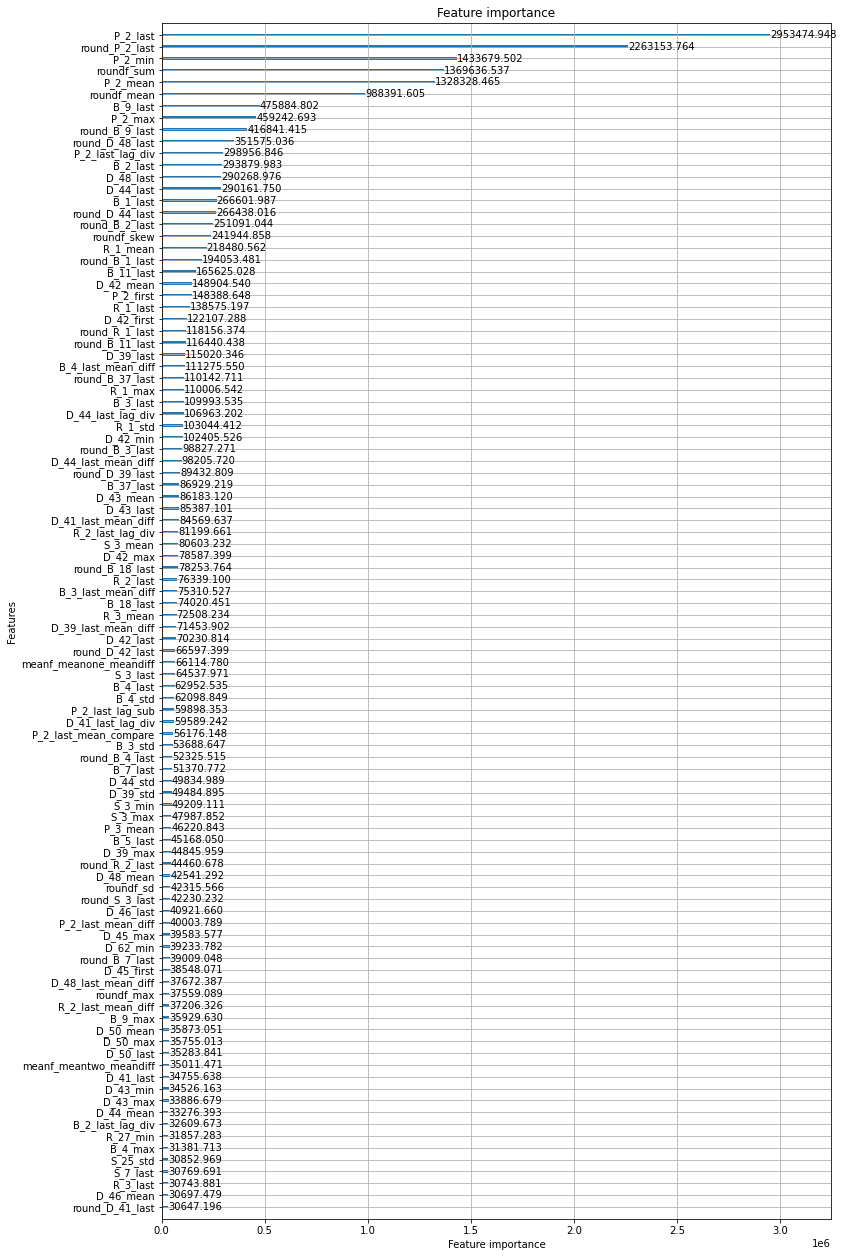

In [8]:
lgb.plot_importance(model, max_num_features=100, importance_type='gain', figsize=(12,22))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

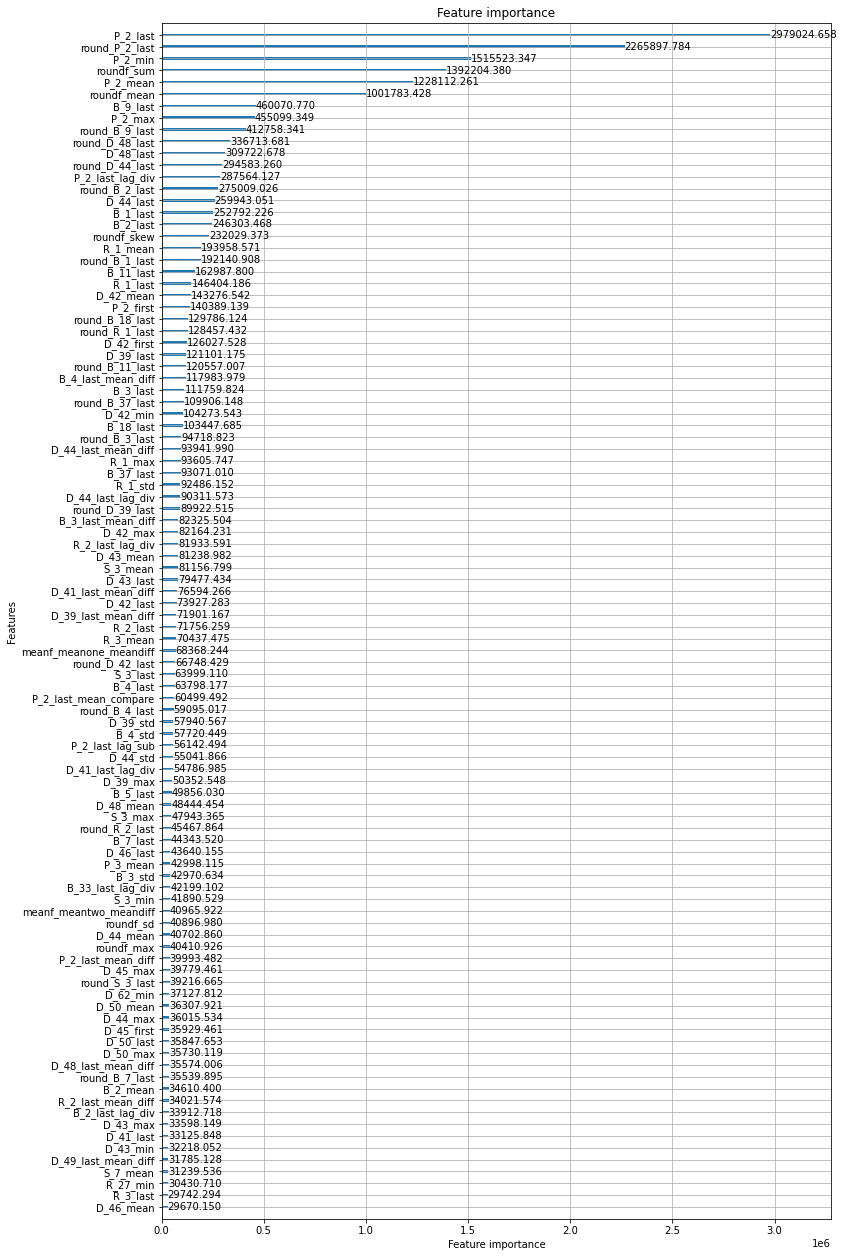

In [6]:
lgb.plot_importance(model, max_num_features=100, importance_type='gain', figsize=(12,22))